<h1><center> Training an Artificial Neural Network using a genetic algorithm</center></h1>

<center> <b>Rafael Monteiro</b>,
    <br>  Mathematics for Advanced Materials - Open Innovation Lab (MathAM-OIL), Japan
<br> rafael.a.monteiro.math "at" gmail.com
    <br><br>  <b>July 9, 2020</b>
    <br><br> 
</center>

In the literature of Artificial Neural Networks (ANNs), the most common form of training involves the using [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent) (GD) using the [Backpropagation Algorithm](https://en.wikipedia.org/wiki/Backpropagation) (BP), which is nothing but the algorithmic design of gradient computations in a neat form (which shoud not be overlooked, for it was a huge step forwards in the field of Machine Learning).


It turns out that BP relies on computations of derivatives. The natural question is then: can we train an ANN without gradient information? 

Yes, we can: we just need to figure out how to explore the parameters' search space. I coded an example (available [here](https://rafael-a-monteiro-math.github.io/Stochastic-Simulations/index.html) in which we perform training  of an ANN using a very simple (somewhat primitive) random search. In fact, if one thinks about GD methods, or any other optimization methods, they are nothing but ways to explore the  parameter space. 


What I will do in the sequel is mainly based inspired by Daniel Hillis seminal paper [Co-evolving parasites improve simulated evolution as an optimization procedure](https://www.sciencedirect.com/science/article/abs/pii/0167278990900762), that I really liked (and strongly recommend). The technique has many names, and is commonly known as **Genetic Algorithms**. There are many books available, and if you are interested you can start by looking here at this MIT OCW course - [Multidisciplinary System Design Optimization](https://ocw.mit.edu/courses/institute-for-data-systems-and-society/ids-338j-multidisciplinary-system-design-optimization-spring-2010/). 

To begin with,  let's generate some data, construct a classical ANN (using [Keras](https://keras.io/)). 

> **Remark:** take a look at [http://playground.tensorflow.org/](http://playground.tensorflow.org/), which is a very  interesting site to see how decision boundaries behave as training evolves through time.

<h2><center>  The classical approach using ANNs </center></h2>

To begin with, let's consider a problem, a simple one, not too complicate. Let's get the libraries we shall need.

In [1]:
#for numerical computations
import numpy as np           

#for plotting
import matplotlib.pyplot as plt   
plt.style.use('ggplot')  # check plt.style.available

#for training classical ANN; we shall also borrow some activation functions from them
import tensorflow as tf

#to generate the dataset
from sklearn.datasets import make_moons

# for train-test splitting
from sklearn.model_selection import train_test_split

## extra
from copy import deepcopy

First we get the dataset

In [2]:
X, Y  = make_moons(noise = .2, n_samples = 400)

color = np.asarray(['purple', 'green'])

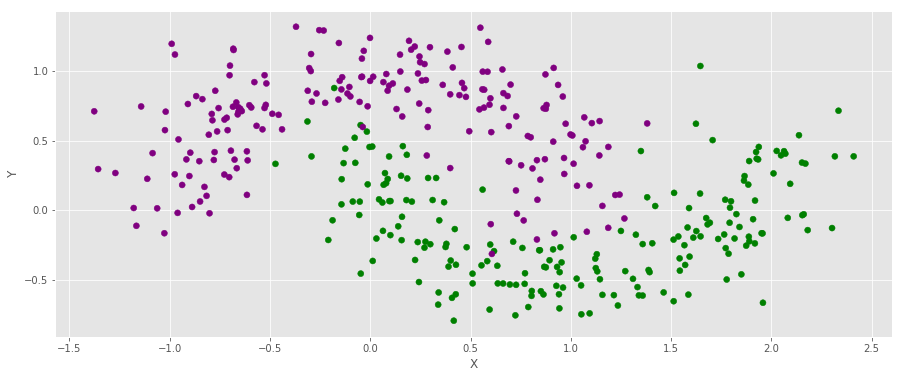

In [3]:
f, ax = plt.subplots(figsize = (15,6))
ax.scatter(X[:,0], X[:,1], c = color[Y])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2)
Y_train, Y_test =  np.reshape(Y_train, (-1, 1)), np.reshape(Y_test, (-1, 1))

Recall that keras considers the data as batch_size X features

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense

keras.backend.clear_session() 
# Neural network
model = Sequential()
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [6]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [7]:
history = deepcopy(model.fit(X_train, Y_train, epochs = 200, batch_size = None, verbose = False))

In [8]:
# fit the keras model on the dataset
_, accuracy_test = model.evaluate(X_test, Y_test)
_, accuracy_train = model.evaluate(X_train, Y_train)

320/320 [==============================] - 0s 32us/step


In [9]:
print(
    "\n The accuracty for the testing set is "+str(np.round(accuracy_test, 4))+\
    "\n The accuracty for the training set is "+str(np.round(accuracy_train, 4))
)


 The accuracty for the testing set is 0.9125
 The accuracty for the training set is 0.8781


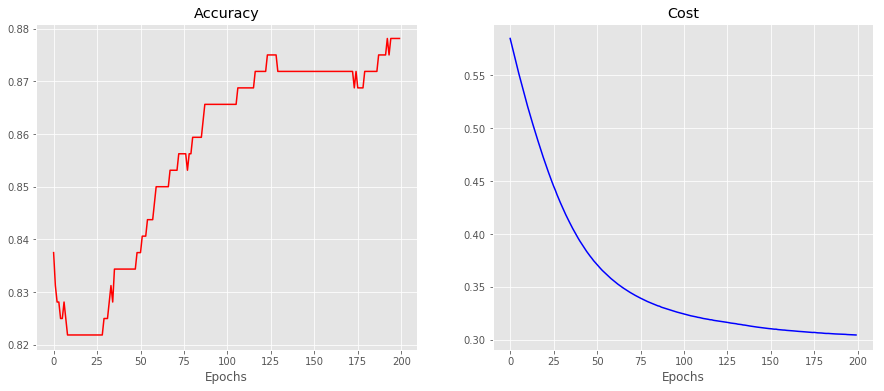

In [10]:
#model.evaluate(X,Y)
f, ax = plt.subplots(ncols = 2, figsize = (15,6))

ax[0].set_title("Accuracy")
ax[0].set_xlabel('Epochs')
ax[0].plot(history.history['accuracy'], c = 'r')

ax[1].set_title("Cost")
ax[1].set_xlabel('Epochs')
ax[1].plot(history.history['loss'], c = 'b')

<h2><center> Genetic Algorithms </center> </h2>

Genetic Algorithms (GA) are somehow inspired by biological plenomena. I will not dwell on the topic that much, just referring briefly to the properties you should know of:
    
>[Genome:](https://en.wikipedia.org/wiki/Gene) it is a sequence of nucleotidis, which as smaller units they are made of. You can imagine it as a vector, where each entry of the vector is a nucleotidis. In general the number of nucleotides is finite, but here we shall allow them to assume any value in the real line.
<br>
<br>
[Mutation:](https://en.wikipedia.org/wiki/Mutation) it consists of a random change that may happen to any entry in a genome. 
<br>
<br>
[Crossover:](https://en.wikipedia.org/wiki/Chromosomal_crossover) it is basically  a process in which a pair of genomes exchange nucleotides. In our case we will do it by defining a cutting point. For instance: given two sequences,$$X_1 \quad \text{and}\quad X_2,$$ if the cutting point is "c" (we shall use python's slicing convention), these two sequences will recombine into two new sequences, 
\begin{align}\label{combination}
\widetilde{X}_{j(mod2)} := X_{j(mod2)}[0:c]\oplus X_{(j+1)(mod2)}[c:],\quad \text{for} \quad  j\in\{0,1\}. \tag{1}\end{align}
For example. when $c=2$, $X_1=  (1,9,8,7)$, and $X_2 = (2,0,2,0)$ we get $\widetilde{X_2} = (1,9,2,0)$ and $\widetilde{X}_2 = (2,0,8,7)$. Needless to say that these two sequences should always have the same length. 
 
There are other types of crossover, and I'll stick with the one explained above. You can read more about Biology at the [Encyclopedia Britannica](https://www.britannica.com/science/human-genetics/Immunogenetics)  website.

As you might have noticed, since mutation and crossover are stochastic, we shall need to define two associated quantities, respectively $p_m$ and $p_c$, to account for them.
<br>

### How does it work?

First, we shall need an "interface" between weights of an ANN, and genomes: we shall be able to map one to the other in a 1-1 way. This part is easy, and will be tackled soon. 

There are other things more important to worry about.

**Genomes?**

This part is somewhat nontrivial, involving a bit of modeling and, mostly, critical thinking: where are the genomes in an ANN? The first thing to do is to think what we are looking at: when we optimize an ANN we are after some "good" weights, based on which the model has good accuracy, or scores well in a certain metric.  In our case then, we shall look at weights as if they were genomes. In order to do that we shall first "flatten" all the layers together, as if they were a long genome.

**Fitness** 

Next, we think about how to measure the fitness of a genome: what makes a sequence better than other? This part is not much far from the classical ANN model, and we shall consider the weights that give a high accuracy of prediction. In a serious project or paper, you should split the dataset into 3 parts, train-dev-test set, but here we shall only use a train-test, and do model assessment by measuring the error on the training set, and testing it on the test set. 

We are looking for some quantity that indicates how well the indiviual "survives" in a certain environment: that is, given an ANN with a certain genome, if it classifies well, all is good and we would like more of that genome in our future propulations (which means, this individual should leave descendants), but if it does not classify well, this ANN will probably not succeed, and shall not leave descendants.  

We shall then measure fitness as a function inversely proportional to the cost function (which in the classical ANN setting must be minimized): the higher (resp. lower) the cost, the less (resp. more) prone to leave decendants the individual is.

<h2><center> Adding a little bit of mathematics to the discussion </center> </h2>

Mathematically, we we will do the following: assuming a population (a set of ANNs' weights) $\mathscr{W}= \left( W_j\right)_{1\leq j \leq N}$, assume a cost function $\mathscr{W}\ni W \mapsto \mathrm{Cost}_{\mathscr{W}}(W)$. Now we associate a probability measure to each individual in this population, 

\begin{align}\label{partition_fnt}
P(W_j) = \frac{ e^{- \beta \mathrm{Cost}_{\mathscr{W}}(W_j)}}{\sum_{m = 1}^N e^{-\beta \mathrm{Cost}_{\mathscr{W}}(W_m)}}, \tag{2}
\end{align}

which plays the role of a [canonical partition function](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics)), as in Statistical Mechanics. The quantity $\beta$ is a quantity that we give, and  is inversely proportional to the temperature in the system; I'll talk more about that towards the end. When $\beta =1$ this function becomes the well known [https://en.wikipedia.org/wiki/Softmax_function](softmax function).

We shall use  \eqref{partition_fnt} as follows: given a population of $N$ individuals, with weights $\mathscr{W}= \left( W_j\right)_{1\leq j \leq N}$, at each step we shall generate a new population with $N$ individuals by selecting from $\mathscr{W}$ with probabilities given by \eqref{partition_fnt}. **Notice that the individual that minimizes the cost function is the one that has the highest probability of being chosen.**

Last, we shall talk about mutations. We shall consider mutations at each entry of the weight matrices, as  a Bernoulli with probability $p_c$ (for now kept constant, but which can mutate at each iteration). If an entry is chosen to mutate, it will do so as a random noise, distributed as a normal variable centered at the origin, with variance 1.

In what follows, I'll assume N even: if it is odd you can "throw away a descendant" at the end of this process. 

Ok, now we are ready to start. We shall define a few things:

1. Initialize  N (random) ANNs randomly, yieding a sequence of ANNs' weights $\mathscr{W}  = \left(W_j\right)_{1\leq j \leq N}$;  
2. Forward propagate each model, generating  the fitness P(W_j) of each weight;
3. Map each element in $\mathscr{W}$ to a space $\mathscr{G}$ of genomes. We shall represent this 1:1 correspondence as $\left(W_j\right)_{1\leq j \leq N} \to \left(G_j\right)_{1\leq j \leq N}$;
4. Select a new generation with N individuals from $\mathscr{G}$, selected with replacement according to \eqref{partition_fnt}. Abusing notation, we shall still represent this generation as $\left(G_j\right)_{1\leq j \leq N}$; 
5. For every 1 \leq j \leq N/2, pair individuals $G_{2j}$ and $ G_{2j+1}$ and crossover with probability $p_c$ at a random point along it's length. This new sequence is still denoted by $\left(G_j\right)_{1\leq j \leq N}$;
6. Now, with a sequence $\left(G_j\right)_{1\leq j \leq N}$ in hands, decide whether to mutate each entry by sampling a Bernoulli with parameter $p_c$: if you get a success (with probability $p_c$), you mutate the entry by adding noise to it - a realization of a normal distribution with variance 1; if you do not mutate, nothing is done and the entry remains the same.
7. Rewrite the genomes as weights: $\left(G_j\right)_{1\leq j \leq N}\to \left(W_j\right)_{1\leq j \leq N}$;
8. Stop, or return to step 3;    

Each time we follow this "recipe" we obtain a new generation (we shall use 150 generations).

<h2><center> Implementating the GA "recipe" </center></h2>

Let's start with the most basic things, which more than any math, involve some project development: we need to decide (i) how to store data and (ii) how to store them as genomes.  We shall do the following: in the kth layer of an  ANN we define the next element as follows:

\begin{align}\label{ANN}
Z^{[k+1]}= W^{[k]}\cdot Z^{[k]} + b^{[k]}; \quad A^{[k+1]} = \sigma(Z^{[k+1]}).\tag{3}
\end{align}

The function $\sigma(\cdot)$ is known as activation function, which in our case will be ReLu units in the hidden layers, and a sigmoid in the last layer. Parameters $W^{[k]}$ and $b^{[k]}$ are the weights (some people also call them "weight and bias", respectively). 

Since we need to train several ANNs, we shall denote by $W_j^{[k]}$ the kth layer of the individual $j$. We shall store all of them as a stack, a 3D array. For instance,  if $W_k$ denotes this 3D matrix, then 
$W[:,:,j]$ corresponds to the matrix $W_j^{[k]}$.

With regards to genomes, we shall store them as a row vector. In this way, if we have a population with size $N$ and genomes of length $l$, all the population genomes will be stored as a matrix $G \in \mathbb{R}^{N\times l}$.

In what follows, we separate the weights as two dictionaries: one contains $W$, adn the other $b$ (see Equation \eqref{ANN}).

In [11]:
class Genomes_and_weights:
    
    def __init__(self):
        pass

    def initialize_weights(self, size, pop_size):
        """
        Initialize weights of pop_size ANNs.
        
        Arguments:
        ----------
        size :  array, where the jth entry correspond to the number of nodes in the jth layer of an ANN.
        pop_size : array, population size.
        """
        
        assert(pop_size%2 == 0)
        N = len(size)
        W, b = {}, {}
        for i in range(N-1):
            W[str(i)] = np.asarray(
                np.random.randn(size[i+1], size[i], pop_size), dtype = 'float32'
            )
            b[str(i)] = np.asarray(
                np.random.randn(size[i+1], 1, pop_size), dtype = 'float32'
            )
        return W, b

    def weights_to_genome(self, W, b):
        """
        Convert weights to genomes, giving a dictionary as output.
        Ech layer W of size (a,b, pop_size) is converted to a matrix of size 
        (pop_size, a*b).
        
        b has size (n_k, 1, pop_size), becoming a (pop_size, n_k).
        
        Arguments:
        ----------
        W : dictionary, with W weights (see Equation 3).
        b : dictionary, with b weights (see Equation 3).
        """
        
        N = len(W.keys())
        pop_size = W["0"].shape[-1]
        genome_W = {}
        genome_b = {}
        for i in range(N):
            genome_b[str(i)] = np.transpose(np.array(np.squeeze(b[str(i)]), ndmin = 2))
            genome_W[str(i)] =  W[str(i)].reshape(-1, pop_size).T

        return genome_W, genome_b

    def genome_to_weights(self, genome_W, genome_b, size):
        """
        Convert genomes back to weights.
        
        Arguments:
        ----------
        genome_W : dictionary, where the  component W of each layer is written as a genome (see Equation 3).
        genome_b : dictionary, where the  component b of each layer is written as a genome (see Equation 3).
        
        """
        
        N = len(genome_W.keys())
        pop_size = genome_W["0"].shape[0]
        W, b = { }, { }
        for i in range(N):
            W[str(i)] =  genome_W[str(i)].reshape(pop_size, size[i+1], size[i])
            W[str(i)] = np.moveaxis(W[str(i)], 0, -1)
            
            b[str(i)] =  genome_b[str(i)].T
            b[str(i)] = b[str(i)].reshape(b[str(i)].shape[0], 1, b[str(i)].shape[1])
            
        return W, b

    def crossover(self, W, p_c):
        """
        For every k in pop_size/2
        cross over W[2*k,:] and W[2*k+1,:]
        W is flat genome
        
        Arguments:
        ----------
        W : dictionary, with W weights (see Equation 3).
        p_c : probability of crossover.
        """
        pop_size = W["0"].shape[0]
        numb_keys = len(W.keys())
        cut = {}

        ### Define cuts
        for i in range(numb_keys):
            length_genome = W[str(i)].shape[1]
            cut_not_cut = np.random.uniform(size = int(pop_size/2)) 
            cut_not_cut = cut_not_cut < p_c
            cut[str(i)] = cut_not_cut * np.random.choice(length_genome, int(pop_size / 2)) 

        ## Perform crossover
        for i in range(numb_keys):
            W_now = W[str(i)]
            for cut_now in range(int(pop_size / 2)):
                aux = np.copy(W_now[2 * cut_now, :])
                W_now[2 * cut_now,cut[str(i)][cut_now]:] = W_now[2 * cut_now + 1, cut[str(i)][cut_now]:]
                W_now[2 * cut_now + 1,cut[str(i)][cut_now]:] = aux[cut[str(i)][cut_now]:]
                ### This is a shallow copy. It will change the dictionary W
    
    def mutate_genome(self, genome, p_m):
        """
        Mutate genome, each entry changing - by a gaussian noise - with probability p_m.
        
        Arguments:
        ----------
        genome : dictionary, contains the genomes of the whole population.
        p_c : probability of crossover.
        """

        pop_size = genome["0"].shape[0]
        numb_keys = len(W.keys())

        for i in range(numb_keys):
            genome_now = genome[str(i)]

            add_mutation = np.random.uniform(size = [pop_size,genome_now.shape[1]]) < p_m
            add_mutation = add_mutation * np.random.randn(pop_size,genome_now.shape[1]) 

            genome_now += add_mutation

`using keras.  The population will have 4 individuals for now. 

Let's see what the above code gives. 

In [12]:
pop_size = 4
ga = Genomes_and_weights()
W, b = ga.initialize_weights([2,4,1], pop_size)

As a whole, the whole population genome in the first layer (which is kind of a chromossome) is stored in W[0] and b["0"] as

In [13]:
print(
    "W[0] = ",\
    W["0"],"\n \n  has  shape ",\
    W["0"].shape,",\n\n and b[0]",\
    b["0"],"\n \n has shape ",\
    b["0"].shape
)

W[0] =  [[[ 1.5290596   0.03652481  0.10042751 -1.4393315 ]
  [ 2.1721115   0.7335153  -1.2901859   1.122072  ]]

 [[-0.4184908   0.42675617  1.0972177  -0.8103931 ]
  [ 1.8723043   0.41565034 -1.1929783   0.16984618]]

 [[-0.45982912 -0.13207749  0.47038814 -1.4355569 ]
  [-0.8660688   0.78804165  1.245616   -0.37979412]]

 [[-1.4317461   0.6232679   0.8716522   0.21763343]
  [-0.37476653 -0.32524735  0.7727888  -0.6329398 ]]] 
 
  has  shape  (4, 2, 4) ,

 and b[0] [[[ 1.0149052   1.5962721   0.5448057  -0.13643746]]

 [[-0.3282249  -0.42788216 -0.22241738  1.1997418 ]]

 [[-0.34408465 -1.3524952   1.1440673  -1.1409839 ]]

 [[ 2.3484023  -2.081399    1.4620366  -0.764921  ]]] 
 
 has shape  (4, 1, 4)


That is, if we want the weights of the first individual $(j=0)$ we do 

In [14]:
print(
    "W_0[0] = ",\
    W["0"][:,:,0]," \n\n has  shape ",\
    W["0"][:,:,0].shape,\
    ",\n\n and b_0[0] = ",\
    b["0"][:,:,0],"\n \n has shape ",\
    b["0"][:,:,0].shape
)


W_0[0] =  [[ 1.5290596   2.1721115 ]
 [-0.4184908   1.8723043 ]
 [-0.45982912 -0.8660688 ]
 [-1.4317461  -0.37476653]]  

 has  shape  (4, 2) ,

 and b_0[0] =  [[ 1.0149052 ]
 [-0.3282249 ]
 [-0.34408465]
 [ 2.3484023 ]] 
 
 has shape  (4, 1)


Now let's convert weights to a sequence of genomes.

In [15]:
genome_W, genome_b = ga.weights_to_genome(W, b)

Let's see what happens to the very same weight we saw above.

In [16]:
print(
    "W_0[0]   has become",\
    genome_W["0"][0,:]," \n\n and now has  shape",\
    genome_W["0"][0,:].shape,",\n \n whereas  b_0[0] has become ",\
    genome_b["0"][0,:],",\n \n and now has shape ",\
    genome_b["0"][0,:].shape
)

W_0[0]   has become [ 1.5290596   2.1721115  -0.4184908   1.8723043  -0.45982912 -0.8660688
 -1.4317461  -0.37476653]  

 and now has  shape (8,) ,
 
 whereas  b_0[0] has become  [ 1.0149052  -0.3282249  -0.34408465  2.3484023 ] ,
 
 and now has shape  (4,)


Let's check if the function that maps genome to weights is working:

In [17]:
W_rec, b_rec = ga.genome_to_weights(genome_W, genome_b,[2,4,1])

In [18]:
print(
    "W_rec[0] = ",\
    W_rec["0"],"\n \n  has  shape ",\
    W_rec["0"].shape,",\n\n and b_rec[0]",\
    b_rec["0"],"\n \n has shape ",\
    b_rec["0"].shape
)

W_rec[0] =  [[[ 1.5290596   0.03652481  0.10042751 -1.4393315 ]
  [ 2.1721115   0.7335153  -1.2901859   1.122072  ]]

 [[-0.4184908   0.42675617  1.0972177  -0.8103931 ]
  [ 1.8723043   0.41565034 -1.1929783   0.16984618]]

 [[-0.45982912 -0.13207749  0.47038814 -1.4355569 ]
  [-0.8660688   0.78804165  1.245616   -0.37979412]]

 [[-1.4317461   0.6232679   0.8716522   0.21763343]
  [-0.37476653 -0.32524735  0.7727888  -0.6329398 ]]] 
 
  has  shape  (4, 2, 4) ,

 and b_rec[0] [[[ 1.0149052   1.5962721   0.5448057  -0.13643746]]

 [[-0.3282249  -0.42788216 -0.22241738  1.1997418 ]]

 [[-0.34408465 -1.3524952   1.1440673  -1.1409839 ]]

 [[ 2.3484023  -2.081399    1.4620366  -0.764921  ]]] 
 
 has shape  (4, 1, 4)


which is exactly what we had before. Nice! So far, so good! 

Let's see if the mutations are working well by printing them side by side

In [19]:
print("Original genome  b is \n \n ",\
    genome_b
)
p_m = 0.5
ga.mutate_genome(genome_b, p_m)
print(
    "\nMutated genome at b is \n \n  ",\
    genome_b
)

Original genome  b is 
 
  {'0': array([[ 1.0149052 , -0.3282249 , -0.34408465,  2.3484023 ],
       [ 1.5962721 , -0.42788216, -1.3524952 , -2.081399  ],
       [ 0.5448057 , -0.22241738,  1.1440673 ,  1.4620366 ],
       [-0.13643746,  1.1997418 , -1.1409839 , -0.764921  ]],
      dtype=float32), '1': array([[-1.9951621 ],
       [-2.743319  ],
       [-1.4085219 ],
       [ 0.48219222]], dtype=float32)}

Mutated genome at b is 
 
   {'0': array([[ 2.6001053 , -0.3282249 , -0.34408465,  1.5458803 ],
       [ 1.5962721 , -0.42788216, -1.3524952 , -2.081399  ],
       [ 0.5448057 , -0.22241738,  1.1440673 ,  1.4620366 ],
       [-1.2513115 ,  1.1997418 , -2.10921   , -0.5708994 ]],
      dtype=float32), '1': array([[-1.9951621 ],
       [-2.743319  ],
       [-0.9622202 ],
       [ 0.48219222]], dtype=float32)}


Ok, it is working well.

Let's test the crossover.


In [20]:
print(
    "Original genome of 0th individual G_0 at 0th layer   is \n \n ",\
    genome_W["0"][0,:]
)
p_c = .5
ga.crossover(genome_W, p_c)
print(
    "\nGenome of of 0th individual G_0 at 0th layer  after crossover is \n \n  ",\
    genome_W["0"][0,:]
)

Original genome of 0th individual G_0 at 0th layer   is 
 
  [ 1.5290596   2.1721115  -0.4184908   1.8723043  -0.45982912 -0.8660688
 -1.4317461  -0.37476653]

Genome of of 0th individual G_0 at 0th layer  after crossover is 
 
   [ 0.03652481  0.7335153   0.42675617  0.41565034 -0.13207749  0.78804165
  0.6232679  -0.32524735]


## Loading weights to a keras model

Let's see if it is easy. The weights at this point are

In [21]:
model.get_weights()

[array([[ 1.3677032 ,  0.6666145 , -0.44910508,  0.56045   ],
        [ 0.8928646 , -1.6080403 ,  1.8076144 , -1.0727608 ]],
       dtype=float32),
 array([-0.14842546,  0.817198  ,  0.51504886,  0.86330694], dtype=float32),
 array([[-0.5304353 ],
        [ 0.89492065],
        [-1.1357013 ],
        [ 1.1182268 ]], dtype=float32),
 array([-0.24260907], dtype=float32)]

let's print their sizes

In [22]:
for w in iter(model.get_weights()):
    print(w.shape)

(2, 4)
(4,)
(4, 1)
(1,)


let's check for W

In [23]:
for i in W.keys():
    print(W[i][:,:,0].shape)
    print(b[i][:,:,0].shape)

(4, 2)
(4, 1)
(1, 4)
(1, 1)


This is not good yet, because keras uses rank one vectors in the label. Let's fix that:

In [24]:
N_layers = len(W.keys())

new_weights =[]
for i in range(N_layers):
    # Recall that W has to be transposed in keras
    new_weights.append(np.transpose(W[str(i)][:,:,0])) 
    new_weights.append(np.transpose(b[str(i)][:,:,0]).reshape(-1))

for i in range(len(new_weights)):
    print(new_weights[i].shape)

(2, 4)
(4,)
(4, 1)
(1,)


ok...now we shall use [set_weights](https://keras.io/api/layers/base_layer/#setweights-method) method.  Let's try

In [25]:
model.set_weights(new_weights)

## Now let's check
print(
    "Model weights in the first layer isis \n \n ",\
    model.get_weights()[0],\
    "\n\nand W[0] is \n \n ",\
    np.transpose(W["0"][:,:,0])
)

Model weights in the first layer isis 
 
  [[ 0.03652481  0.42675617 -0.13207749  0.6232679 ]
 [ 0.7335153   0.41565034  0.78804165 -0.32524735]] 

and W[0] is 
 
  [[ 0.03652481  0.42675617 -0.13207749  0.6232679 ]
 [ 0.7335153   0.41565034  0.78804165 -0.32524735]]


Great! This is all we need. In order to predict we shall use "model.predict_classes(X)"

> **Remark:** it is also possible to do everything by hand using tensorflow. In fact, the first version of this code was written. Using keras is much faster though.

## Propagate the model


I wrote a tensorflow implementation of the model below, using [sigmoid_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Since we now know how to feed the weights to a keras model we shall stick with the latter approach.  

The code will not be efficient because it is not vectorized (on population). Apparently there is a nicer way to implement using keras. Keras was mainly designed for CNN's, therefore it has many nice 3D matrices computations (like multiplications, convolutions and so) already implemented. 

https://www.tensorflow.org/api_docs/python/tf/keras/backend/dot

For this example this is not a big deal. In real application, this can be important.

In [26]:
class GA_Model:
    
    def __init__(self):
        pass
    
    def forward_using_keras(self, model, X, Y, W, b, j):
        """
        Forward propagate the jth individual ANN
        with input X, label Y, weights W and b  of the whole population in a given list, 
        where ith entry of the latter corresponds to 
        the ith layer (see discussion above).
        
        Arguments:
        ----------        
        model: keras model
        X : features, as batch_size X features.
        Y : labels, as batch_size X {0,1}.
        W : dictionary, with W weights (see Equation 3).
        b : dictionary, with b weights (see Equation 3).
        j : integer, individual number.
        """
        N_layers = len(W.keys())

        new_weights = [ ]
        for i in range(N_layers):
            # Recall that W has to be transposed in keras
            new_weights.append(np.transpose(W[str(i)][:,:,j])) 
            new_weights.append(np.transpose(b[str(i)][:,:,j]).reshape(-1))
        
        model.set_weights(new_weights)
        loss, accuracy = model.evaluate(X, Y, verbose = False)
        
        return loss, accuracy
        
    def fwd_propagate_population_keras(self,model, X, Y, W, b):
        """
        Forward propagate the whole population genome as ANNs,
        with input X, label Y, weights W and b  of the whole population in a given list, 
        where ith entry of the latter corresponds to 
        the ith layer (see discussion above).
        
        Arguments:
        ----------        
        model: keras model
        X : features, as batch_size X features.
        Y : labels, as batch_size X {0,1}.
        W : dictionary, with W weights (see Equation 3).
        b : dictionary, with b weights (see Equation 3).
        """
        N_layers = len(W.keys())+1
        pop_size = W["0"].shape[-1]
        cost = [ ]
        predict = [ ]
        for gen_now in range(pop_size):             
            cost_now , pred_now = self.forward_using_keras(model, X, Y, W, b, gen_now)
            cost.append(cost_now)
            predict.append(pred_now)

        self.cost = cost
        self.predict  = predict
    
    def genome_score(self, cost,  genome_W, genome_b, beta = 10):
        """
        Return a new population of genomes, selected randomly according to the partition function 
        (see Equation 3).
        
        Arguments:
        ----------
        genome_W : dictionary, where the  component W of each layer is written as a genome (see Equation 3).
        genome_b : dictionary, where the  component b of each layer is written as a genome (see Equation 3).
        beta : parameters used for the partition function (see Equation 3).
        cost : accuracy associated to an ANN with corresponding weights (given by genome_{W,b});
               used as parameter in the partition function (see Equation 3).
        """
        pop_size = genome_W["0"].shape[0]
        
        costs = self.cost
        p_c = beta_softmax(beta, costs)
        selected = np.random.choice(pop_size,pop_size, p = p_c)
        N_layers = len(W.keys())
        
        for i in range(N_layers):
            genome_W[str(i)] = genome_W[str(i)][selected,:]
            genome_b[str(i)] = genome_b[str(i)][selected,:]
        
        return genome_W, genome_b        
        
def beta_softmax(beta, Z):
    """
    Return a selection of genomes by order of preference

    Arguments:
    ----------
    beta : parameters used for the partition function
    
    """
    a =  tf.nn.softmax(logits = -beta * tf.constant(Z))
    return a.numpy()

Let's test it.

In [28]:
ga_model = GA_Model()
W["1"][:,:,0].shape,b["1"][:,:,0].shape

((1, 4), (1, 1))

In [29]:
ga_model.fwd_propagate_population_keras(model, X_train,Y_train, W,b)
prob = ga_model.cost

In [30]:
N_generations = 1
pop_size = 4

layer_sizes = [2,2,1]
ga_model = GA_Model()
ga = Genomes_and_weights()

p_m = 0.01  # probability of mutation
p_c = 0.7   # probability of crossover

W, b = ga.initialize_weights(layer_sizes,pop_size)


print("W",W["1"].shape,W["1"])

W (1, 2, 4) [[[-0.2742074   0.2176395  -1.4531696  -0.9095396 ]
  [-0.22977498 -0.40075365  0.11204707 -0.7837196 ]]]


In [31]:
genome_W, genome_b = ga.weights_to_genome(W, b)

In [32]:
ga.mutate_genome(genome_W, p_m)
ga.mutate_genome(genome_b, p_m)
W_r, b_r = ga.genome_to_weights(genome_W, genome_b,layer_sizes) 

In [33]:
print("W_r",W_r["1"].shape,W_r["1"])

W_r (1, 2, 4) [[[-0.2742074   0.2176395  -1.4531696  -0.9095396 ]
  [-0.22977498 -0.40075365  0.11204707 -0.7837196 ]]]


Great! Everything is working good in this part. At this point one could check the rest of the code to see if the crossover is working. I'll leave it to you as an exercise. 

<h2> <center>Implementation  </center></h2> 


First we set up the parameters:

In [34]:
N_generations = 200
pop_size = 100

layer_sizes = [2,4,1]

ga_model = GA_Model()
genome_and_weights = Genomes_and_weights()

p_m = 0.005  # probability of mutation
p_c = 0.8   # probability of crossover

In [35]:
Save_results = { }

for test in range(20):
    accuracy_train = [ ]
    accuracy_test = [ ]
    W, b = genome_and_weights.initialize_weights(layer_sizes,pop_size)
    print("\n Test number \t", test)
    
    for i in range(N_generations):
        cost = ga_model.fwd_propagate_population_keras(model, X_train, Y_train, W, b)

        genome_W, genome_b = genome_and_weights.weights_to_genome(W, b)
        genome_W, genome_b = ga_model.genome_score(cost, genome_W, genome_b)
        # crossover
        genome_and_weights.crossover(genome_W, p_c)
        genome_and_weights.crossover(genome_b, p_c)
        # mutation
        genome_and_weights.mutate_genome(genome_W, p_m)
        genome_and_weights.mutate_genome(genome_b, p_m)

        W, b = genome_and_weights.genome_to_weights(genome_W, genome_b,layer_sizes)

        ## Get accuracy
        all_costs = np.array(ga_model.cost, ndmin = 1)
        m = np.min(np.squeeze(np.asarray(np.where(all_costs == np.min(all_costs)))))
        # Training set    
        _, predict_train = ga_model.forward_using_keras(model, X_train, Y_train, W, b, m)
        accuracy_train.append(predict_train)
        # Test set
        _, predict_test = ga_model.forward_using_keras(model, X_test, Y_test, W, b, m)
        accuracy_test.append(predict_test)
        
    Save_results[str(test)] = [accuracy_test,accuracy_train]


 Test number 	 0

 Test number 	 1

 Test number 	 2

 Test number 	 3

 Test number 	 4

 Test number 	 5

 Test number 	 6

 Test number 	 7

 Test number 	 8

 Test number 	 9

 Test number 	 10

 Test number 	 11

 Test number 	 12

 Test number 	 13

 Test number 	 14

 Test number 	 15

 Test number 	 16

 Test number 	 17

 Test number 	 18

 Test number 	 19


Now let's plot some graphs. I'll need some extra libraries for that

In [36]:
## To zoom in part of the graph we will use these libraries
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# To customize legend
from matplotlib.lines import Line2D

In [37]:
number_runs = 20
Accuracy_test = np.zeros([number_runs, N_generations])
Accuracy_train = np.zeros([number_runs, N_generations])

for test in range(number_runs):
    Accuracy_test[test,:] =  Save_results[str(test)][0]
    Accuracy_train[test,:] =  Save_results[str(test)][1]

In [38]:
av_test = np.average(Accuracy_test,axis=0)
std_test = np.std(Accuracy_test,axis=0)

av_train = np.average(Accuracy_train,axis=0)
std_train = np.std(Accuracy_train,axis=0)

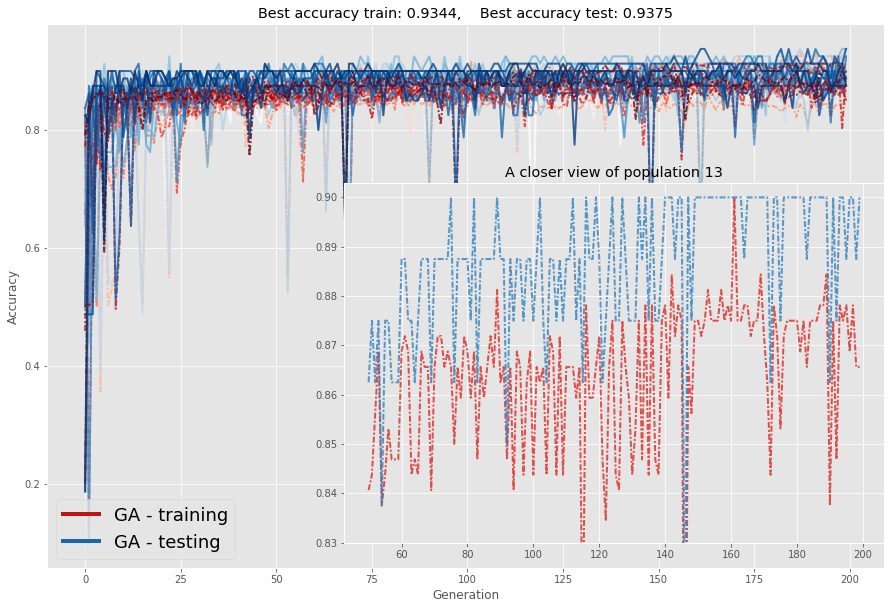

In [44]:
f, ax = plt.subplots(figsize=(15,10))
axins = plt.axes([0.4, 0.16, 0.5,0.5])

cmap_test=plt.cm.Blues(np.linspace(0,1,number_runs))
cmap_train=plt.cm.Reds(np.linspace(0,1,number_runs))

L = 50

for i in range(number_runs):
    ax.plot(Accuracy_train[i,0:],lw = 2,linestyle=(0,(3,1,1,1)), alpha = .8, color=cmap_train[i])
    ax.plot(Accuracy_test[i,0:],lw = 2,linestyle='-', alpha = .8,color=cmap_test[i])
    
    if i==13:
        axins.set_title("A closer view of population "+str(i))
        axins.plot(
            np.arange(N_generations)[L:],Accuracy_train[i,L:],\
            lw = 2,linestyle=(0,(3,1,1,1)), alpha = .8,color=cmap_train[i]
        )
        axins.plot(
            np.arange(N_generations)[L:],Accuracy_test[i,L:],\
            lw = 2,linestyle=(0,(3,1,1,1)), alpha = .8,color=cmap_test[i]
        )

        axins.set_ylim(0.83,.903)

ax.set_title(
    "Best accuracy train: "+str(np.round(np.max(Accuracy_train),4))+",\
    Best accuracy test: "+str(np.round(np.max(Accuracy_test),4))
)

ax.set_xlabel("Generation")
ax.set_ylabel("Accuracy")

## Custom legend
legend_elements = [Line2D([0], [0], color = cmap_train[15], lw=4, label='GA - training'),
                   Line2D([0], [0], color = cmap_test[15], lw=4, label='GA - testing')]
ax.legend(handles = legend_elements,fontsize= 18, loc = 3)

ax.grid(True)
plt.show()

It is somehow better to see the average and standard deviation of these runs. One caveat that you should be aware of is that averaging removes a lot of the oscillation you see in each realization of this process; the standard deviation (represented as a shadow) helps a little,  keeping part of this information in the plot. 

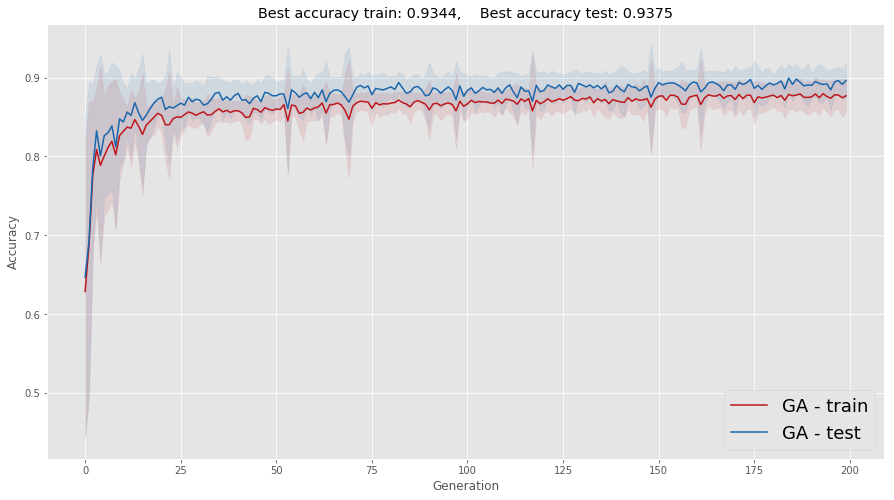

In [45]:
f, ax = plt.subplots(figsize = (15,8))
ax.plot(
    av_train, color = cmap_train[15], label = 'GA - train'
)
ax.plot(
    av_test, color = cmap_test[15], label = 'GA - test'
)
ax.set_title(
    "Best accuracy train: "+str(np.round(np.max(Accuracy_train),4))+",\
    Best accuracy test: "+str(np.round(np.max(Accuracy_test),4))
)
x_domain_plot = np.arange(len(av_train-std_train))

# Shaded part with st deviation information
ax.fill_between(
    x_domain_plot, av_train - std_train, av_train + std_train,color = cmap_train[15], alpha =.1
)
ax.fill_between(
    x_domain_plot, av_test - std_test, av_test + std_test, color = cmap_test[15], alpha =.1
)
ax.set_xlabel("Generation")
ax.set_ylabel("Accuracy")
ax.legend(fontsize = 18, loc = 4)
ax.grid(True)
plt.show()

In summary, we can get results that are even better than those using the "classical" backpropagation approach. Notice that this is heavily dependant on the fact that the problem is not that high dimensional, i.e., not many parameters to tubne by optimization. For high dimensional problems a hybrid approach is probably more apropriate. 

## Can we improve these results?

Surely we can! I will leave some ideas below, you can try to find others. I also strongly recommend Hillis' paper: it is full of nice ideas. 

> 1. **Varying $\beta$:** in the function "beta_softmax" there is a parameter beta. It plays the role of the Boltzmann constant (that's what inspired me, actually), which is proportional to 1/T, where T is the temperature. The idea could be to take $T \downarrow 0$, in what is known as quenching. In each epoch we could lower T a little (hence making $\beta$ a bit larger). Physically, doing it too fast is known as quenching, whereas doing it slowly is known as anneling. Some people call it "tempering". As an optimization technique, this idea became widespread after an interesting paper by Fitzpatrick and others in the 80s.
2. **Desing different crossovers:** I only did one type, where we choose a point in the genome and cut. But why not crossing over in many different points? That would be possible too
3. **Diminishing the mutation probability and crossover probability through time**: this is similar to the idea 1.

The range of possibilities is enormous. If you are really interested you should take a look at Hillis' paper and at the MIT OCW reference. 
